# WOD OSD Oxygen: global 1x1 bin
- annual netCDF output
- WOD OSD data
- 1965 to 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import pandas as pd
import os

In [2]:
# define standard depth
zstd=np.array([0.00e+00, 5.00e+00, 1.00e+01, 1.50e+01, 2.00e+01, 2.50e+01,
       3.00e+01, 3.50e+01, 4.00e+01, 4.50e+01, 5.00e+01, 5.50e+01,
       6.00e+01, 6.50e+01, 7.00e+01, 7.50e+01, 8.00e+01, 8.50e+01,
       9.00e+01, 9.50e+01, 1.00e+02, 1.25e+02, 1.50e+02, 1.75e+02,
       2.00e+02, 2.25e+02, 2.50e+02, 2.75e+02, 3.00e+02, 3.25e+02,
       3.50e+02, 3.75e+02, 4.00e+02, 4.25e+02, 4.50e+02, 4.75e+02,
       5.00e+02, 5.50e+02, 6.00e+02, 6.50e+02, 7.00e+02, 7.50e+02,
       8.00e+02, 8.50e+02, 9.00e+02, 9.50e+02, 1.00e+03, 1.05e+03,
       1.10e+03, 1.15e+03, 1.20e+03, 1.25e+03, 1.30e+03, 1.35e+03,
       1.40e+03, 1.45e+03, 1.50e+03, 1.55e+03, 1.60e+03, 1.65e+03,
       1.70e+03, 1.75e+03, 1.80e+03, 1.85e+03, 1.90e+03, 1.95e+03,
       2.00e+03, 2.10e+03, 2.20e+03, 2.30e+03, 2.40e+03, 2.50e+03,
       2.60e+03, 2.70e+03, 2.80e+03, 2.90e+03, 3.00e+03, 3.10e+03,
       3.20e+03, 3.30e+03, 3.40e+03, 3.50e+03, 3.60e+03, 3.70e+03,
       3.80e+03, 3.90e+03, 4.00e+03, 4.10e+03, 4.20e+03, 4.30e+03,
       4.40e+03, 4.50e+03, 4.60e+03, 4.70e+03, 4.80e+03, 4.90e+03,
       5.00e+03, 5.10e+03, 5.20e+03, 5.30e+03, 5.40e+03, 5.50e+03],
      dtype='float32')

In [3]:
# data source identification
#
Nlev=47 # focus on the upper 1,000m
#
dosd='OSD/ocldb1652320646.21862_OSD'
Nosd=12 # number of source files
#
dctd='CTD/ocldb1652320821.23566_CTD'
Nctd=3
#
dirname='intermed_files'
os.system('mkdir -p '+dirname)

0

In [4]:
def monthly_1deg_bin(Nlev,year):
    # prepare array
    dd_osd=np.zeros((12,Nlev,180,360),dtype='int')
    sumo2_osd=np.zeros((12,Nlev,180,360))
    dd_prof=np.zeros((12,180,360),dtype='int')
    # set 1deg lon-lat grid
    Xw=np.arange(-180,180,1)
    Ys=np.arange(-90,90,1)
    # loop over each WOD ragged netCDF file
    for f in range(Nosd):
        if f==0:
            fn=dosd+'.nc'
        else:
            fn=dosd+str(f+1)+'.nc'
        #print('processing '+fn)
        dsosd=xr.open_dataset(fn)
        # now loop over each cast in the netCDF file
        timeloc = pd.DatetimeIndex(dsosd['time'])
        Nprof0=np.size(timeloc)
        yearloc = timeloc.year
        uyear=np.unique(yearloc)
        if uyear[0]==1770:
            minyr=uyear[1]
        else:
            minyr=uyear[0]
        maxyr=uyear[-1]
        if (maxyr < year) | (minyr > year):
            note='skipping non-overlapping years...'
        else:
            print('num of prof = '+str(Nprof0)+' max year = '+str(maxyr)+' min year = '+str(minyr))
            print('reading data...')
            lonloc=dsosd['lon'].to_numpy()
            latloc=dsosd['lat'].to_numpy()
            zrsize=dsosd['z_row_size'].to_numpy()
            orsize=dsosd['Oxygen_row_size'].to_numpy()
            # get depth data
            zp0=dsosd['z'].to_numpy()
            # get tracer data
            o2p0=dsosd['Oxygen'].to_numpy()
            oflg0=dsosd['Oxygen_WODflag'].to_numpy()
            # get month 
            monloc = timeloc.month
            zlevidx=0
            o2levidx=0
            lonloc[lonloc==-180.0]=-179.99
            for nn in range(Nprof0):
                # current year and month
                mind=int(monloc[nn])-1
                yrnow=yearloc[nn]
                # determine x,y,month grid
                xind=np.where((Xw>=lonloc[nn]-1)&(Xw<lonloc[nn]))[0][0]
                yind=np.where((Ys>=latloc[nn]-1)&(Ys<latloc[nn]))[0][0]
                # determine the number of samples in this particular profile
                o2inc=orsize[nn]
                # obtain depth of the samples
                zp1=zp0[zlevidx:int(zlevidx+zrsize[nn])]
                # check if O2 data exists
                if np.isnan(o2inc):
                    tmp_note='no o2 data'
                else:
                    # get the O2 profile and its quality flag
                    Nz1=int(o2inc)
                    o2p1=o2p0[o2levidx:int(o2levidx+o2inc)]
                    oflg1=oflg0[o2levidx:int(o2levidx+o2inc)]
                    o2levidx=int(o2levidx+o2inc) 
                    # vertical level limits to Nz
                    if (Nz1>Nlev):
                        Nz1=Nlev
                    # count the number of profiles 
                    dd_prof[mind,yind,xind]=dd_prof[mind,yind,xind]+1
                    for k in range(Nz1):
                        if (oflg1[k]==0)&(yrnow==year):
                            sumo2_osd[mind,k,yind,xind]=sumo2_osd[mind,k,yind,xind]+o2p1[k]
                            dd_osd[mind,k,yind,xind]=dd_osd[mind,k,yind,xind]+1
                    # --- done within profile loop
                # -------
                # now update the index for Z and go to the next profile
                zlevidx=int(zlevidx+zrsize[nn])
            # check if the number of sample matches up for the entire WOD file
            Nobs0=np.size(zp0)
            if zlevidx!=Nobs0:
                print('error! number of sample did not match')
            else:
                print('passed the sample count check')
    return sumo2_osd,dd_osd,dd_prof

In [5]:
def save_1deg_bin(dsum,dd,xc,yc,zc,year,var,dprof):
    fn=dirname+'/'+var+'_1x1bin_osd_'+str(year)+'.nc'
    dave=dsum/dd
    mon=np.arange(1,13,1)
    da=xr.DataArray(data=dave,name=var,dims=['mon','depth','lat','lon'],\
                coords={'mon':mon,'depth':zc,'lat':yc,'lon':xc})
    ds=da.to_dataset()
    dd=xr.DataArray(data=dd,name='sample_count',dims=['mon','depth','lat','lon'],\
                    coords={'mon':mon,'depth':zc,'lat':yc,'lon':xc})
    ds['sample_count']=dd
    ddp=xr.DataArray(data=dprof,name='profile_count',dims=['mon','lat','lon'],\
                    coords={'mon':mon,'lat':yc,'lon':xc})
    ds['profile_count']=ddp
    # write out the output file
    ds.to_netcdf(fn)
    return 1

In [6]:
YR=np.arange(1965,2022,1)
xc=np.arange(-180,180,1)+.5
yc=np.arange(-90,90,1)+.5
zc=zstd[:Nlev]
for yr in YR:
    print('=== working on '+str(yr)+' ===')
    sumo2,dd,dprof=monthly_1deg_bin(Nlev,yr)
    dummy=save_1deg_bin(sumo2,dd,xc,yc,zc,yr,'o2',dprof)

=== working on 1965 ===
num of prof = 80628 max year = 1965 min year = 1958
reading data...
passed the sample count check
num of prof = 80985 max year = 1970 min year = 1965
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1966 ===
num of prof = 80985 max year = 1970 min year = 1965
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1967 ===
num of prof = 80985 max year = 1970 min year = 1965
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1968 ===
num of prof = 80985 max year = 1970 min year = 1965
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1969 ===
num of prof = 80985 max year = 1970 min year = 1965
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1970 ===
num of prof = 80985 max year = 1970 min year = 1965
reading data...
passed the sample count check
num of prof = 74780 max year = 1973 min year = 1970
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1971 ===
num of prof = 74780 max year = 1973 min year = 1970
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1972 ===
num of prof = 74780 max year = 1973 min year = 1970
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1973 ===
num of prof = 74780 max year = 1973 min year = 1970
reading data...
passed the sample count check
num of prof = 76743 max year = 1977 min year = 1973
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1974 ===
num of prof = 76743 max year = 1977 min year = 1973
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1975 ===
num of prof = 76743 max year = 1977 min year = 1973
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1976 ===
num of prof = 76743 max year = 1977 min year = 1973
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1977 ===
num of prof = 76743 max year = 1977 min year = 1973
reading data...
passed the sample count check
num of prof = 76364 max year = 1982 min year = 1977
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1978 ===
num of prof = 76364 max year = 1982 min year = 1977
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1979 ===
num of prof = 76364 max year = 1982 min year = 1977
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1980 ===
num of prof = 76364 max year = 1982 min year = 1977
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1981 ===
num of prof = 76364 max year = 1982 min year = 1977
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1982 ===
num of prof = 76364 max year = 1982 min year = 1977
reading data...
passed the sample count check
num of prof = 75600 max year = 1986 min year = 1982
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1983 ===
num of prof = 75600 max year = 1986 min year = 1982
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1984 ===
num of prof = 75600 max year = 1986 min year = 1982
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1985 ===
num of prof = 75600 max year = 1986 min year = 1982
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1986 ===
num of prof = 75600 max year = 1986 min year = 1982
reading data...
passed the sample count check
num of prof = 73917 max year = 1990 min year = 1986
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1987 ===
num of prof = 73917 max year = 1990 min year = 1986
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1988 ===
num of prof = 73917 max year = 1990 min year = 1986
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1989 ===
num of prof = 73917 max year = 1990 min year = 1986
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1990 ===
num of prof = 73917 max year = 1990 min year = 1986
reading data...
passed the sample count check
num of prof = 71729 max year = 1995 min year = 1990
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1991 ===
num of prof = 71729 max year = 1995 min year = 1990
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1992 ===
num of prof = 71729 max year = 1995 min year = 1990
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1993 ===
num of prof = 71729 max year = 1995 min year = 1990
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1994 ===
num of prof = 71729 max year = 1995 min year = 1990
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1995 ===
num of prof = 71729 max year = 1995 min year = 1990
reading data...
passed the sample count check
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1996 ===
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1997 ===
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1998 ===
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 1999 ===
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2000 ===
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2001 ===
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2002 ===
num of prof = 70889 max year = 2002 min year = 1995
reading data...
passed the sample count check
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2003 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2004 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2005 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2006 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2007 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2008 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2009 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2010 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2011 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2012 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2013 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2014 ===
num of prof = 76612 max year = 2014 min year = 2002
reading data...
passed the sample count check
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2015 ===
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2016 ===
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2017 ===
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2018 ===
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2019 ===
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2020 ===
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


=== working on 2021 ===
num of prof = 26996 max year = 2021 min year = 2014
reading data...
passed the sample count check


/var/folders/s6/962q46653xd_fxwlc18l0t8w00bhjp/T/ipykernel_87367/2398402837.py:3: RuntimeWarning: invalid value encountered in true_divide
  dave=dsum/dd


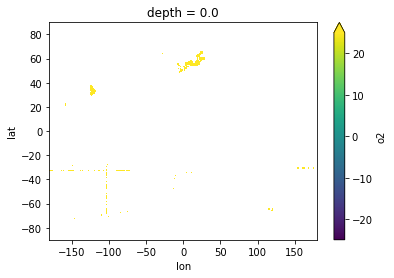

In [15]:
year=2017
ds=xr.open_dataset(dirname+'/o2_1x1bin_osd_'+str(year)+'.nc')
ds.o2.isel(depth=0).mean('mon').plot(vmin=-25,vmax=25)